# The Newsvendor Problem

The newsvendor problem is probably the most well-known stochastic optimization problem. It is well-suited to provide an introduction into the topic. Moreover, it can be easily solved analytically, which turns it into a valuable benchmark.

In [1]:
from pyquasar import *
%matplotlib inline

## The Stochastic Optimization Model

The newsvendor can buy $b$ newspapers at cost $c$ and sell them at price $p$, where sales $s$ are a function of the random demand $D$. The objective of the newsvendor is to buy the optimal number of newspapers that maximizes its profits. Formulated as a stochastic optimization model, the decision problem would be given by
$$\begin{align}
\max_{b,s(D)} \ &-cb + \mathbb{E}\left[ p s(D)\right] \\
s.t. \  & s(D) \leq b \\
& s(D) \leq D 
\end{align}$$
Typically, we would restrict $b$ and $s$ to be positive, but since we want to compare the result of the approximation with the analytic solution, we assume that $b$ and $s$ could take on negative values. This may not lead to a reasonable interpretation for the decision problem described above, but it would still yield a valid optimization problem.

### Parameters

In [2]:
price = 1; cost = 0.2; mean_demand = 20; std_deviation = 5

### Problem Formulation

The model implementation is quite straightforward, but keep in mind, that we are solving the problem using dynamic programming. This means that we must add bounds to the buying decision in order to avoid unboundedness during the solution process. Also, since demand can be negative, the selling decision must be unbounded.

In [3]:
model = DecisionProblem()
buy = model.add_variable(0, "buy", ub=1000)
sell = model.add_variable(1, "sell", lb=float("-inf"))
model += price*sell - cost*buy
model += sell <= buy
model += sell <= rand("demand")

Let us take a look at how the string representation of the variable <code>model</code> to see how the problem is represented internally.

In [4]:
print model

Maximize
obj: -0.2 buy_0 
+ sell_1 
Subject To
sell_1 - buy_0 <= 0.0
sell_1 <= rand(demand)
Bounds
0.0 <= buy_0 <= 1000.0
- infinity <= sell_1 <= + infinity
End


### Random Demand
To model demand, we are going to create a univariate stochastic process with stagewise independence. The process is not restricted to a two-stage decision problem, although in this case, we only use it as our model of demand uncertainty for stage two.

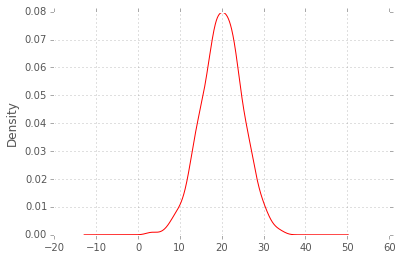

In [5]:
demand_process = univariate.Independent(name='demand', dist='normal', 
                                        mu=mean_demand, sigma=std_deviation, seed=191)
sample = demand_process.simulate(num_stages=2, sample_size=1000)
sample.query('stage==0').demand.plot(kind='kde', color = 'r')

## Solution Method
Let us solve the model using QUASAR's dynamic optimizer. The method is a complete overkill for this simple problem, but it will serve its purpose.

In [6]:
opt = DynamicOptimizer(model, demand_process, num_nodes=50)
opt.solve()
opt.join()

### The Approximate Solution

In [7]:
first_stage_solution = opt.policy.first_stage_solution()
print "buy = %.4f"%first_stage_solution.decisions['buy']

buy = 24.3507


### The Analytic Solution

The analytic solution to the newsvendor problem is given by
$$ F_D^{-1}\left(\frac{p-c}{p}\right)$$
We are going to use SciPy's inverse normal to compute a result.

In [8]:
from scipy.stats import norm
fractile = (price-cost)/price
optimal_buy = norm.ppf(fractile, loc=mean_demand, scale=std_deviation)
print "buy = %.4f"%optimal_buy

buy = 24.2081


### Simulation Output Analysis

profit = 14.5732


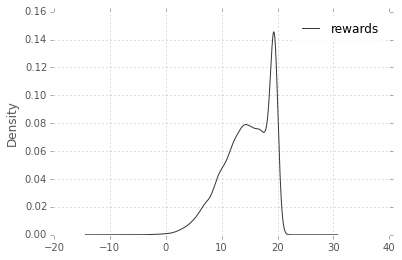

In [9]:
sim = opt.policy.simulate(sample_size=10000, process=demand_process)
print "profit = %.4f"%sim.rewards.groupby_series.sum().mean()
sim.rewards.groupby_series.sum().plot(kind='kde')
plt.show()

## Solution under a Risk Measure
One nice thing about using a stochastic optimizer to solve the problem is that we can easily change the objective criterion and instead of maximizing the expected profit, we minimize the expected tail loss. This requires us to use a risk measure. A popular risk measure is the value-at-risk. Since the value-at-risk is difficult to optimize, we use the conditional value-at-risk, which serves the same purpose.

The objective now changes from maximizing the expected reward to maximizing the expected profit below the $\alpha=0.05$ quantile. We are therefore going to add the keyword <code>nested_cvar=[alpha,lambda,max_iterations]</code> as argument to the constructor call <code>DynamicOptimizer</code>.

In [10]:
opt = DynamicOptimizer(model, demand_process, num_nodes=50, 
                       nested_cvar=[0.05,1.0,len(opt.stats)])
opt.solve()
opt.join()

#### Remarks
- By setting $\lambda=1.0$, we put all weight on minimizing the expected tail los and zero weight on maximizing the expected profit. If we set $\lambda=0.5$, we would use a weighted combination of the two objective criteria.
- With this risk measure, the dynamic optimizer does not know when it has converged. As maximum number of iterations, we therefore use the number of iterations at which the expectation maximizer from the previous solve has converged.

### Buying Decision and Reward Distribution

buy = 11.5173
profit = 9.1107


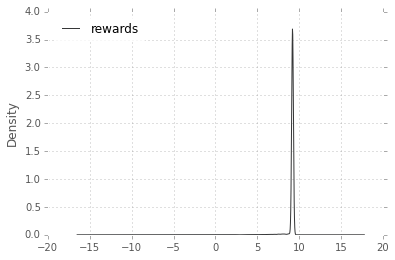

In [11]:
print "buy = %.4f"%opt.policy.first_stage_solution().decisions['buy']
sim = opt.policy.simulate(sample_size=10000, process=demand_process)
print "profit = %.4f"%sim.rewards.groupby_series.sum().mean()
sim.rewards.groupby_series.sum().plot(kind='kde')
plt.show()